In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import statistics
import numpy as np
from csv import writer 
import math
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [6]:
training_data = pd.read_csv("data/train.csv")
training_data["full_text_lower"] = training_data["full_text"].astype(str).str.lower()
cleaned_data = pd.read_csv("data/cleaned.csv")

# Data Loading and Cleaning

We cleaned our data in another notebook. Specifically we removed contractions, lemmatized and got rid of spelling errors. In the end, we used the BERT tokenizer which takes care of these problems on its own. 

In [7]:
training_data.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,full_text_lower
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,i think that students would benefit from learn...
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,when a problem is a change you have to let it ...
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,"dear, principal\n\nif u change the school poli..."
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,the best time in life is when you become yours...
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,small act of kindness can impact in other peop...


In [8]:
cleaned_data.head()

,Unnamed: 0,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,text_n,text_nc,text_lmtz,text_spelling,no. spelling error,wrong_spelling,correct_spelling
0,0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,i think that students would benefit from learn...,i think that students would benefit from learn...,i think that student would benefit from learni...,i think that students would benefit from learn...,1,['cloths'],['clothes']
1,1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,when a problem is a change you have to let it ...,when a problem is a change you have to let it ...,when a problem is a change you have to let it ...,when a problem is a change you have to let it ...,3,"['tings', 'wok', 'ruing']","['things', 'work', 'ring']"
2,2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,"dear, principal if u change the school policy...","dear, principal if you change the school poli...",dear principal if you change the school policy...,dear principal if you change the school policy...,0,[],[]
3,3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,the best time in life is when you become yours...,the best time in life is when you become yours...,the best time in life is when you become yours...,the best time in life is when you become yours...,0,[],[]
4,4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,small act of kindness can impact in other peop...,small act of kindness can impact in other peop...,small act of kindness can impact in other peop...,small act of kindness can impact in other peop...,12,"['kindess', 'homeles', 'triying', 'greate', 'k...","['kindness', 'homeless', 'trying', 'create', '..."


# Exploratory Data Analysis and Preliminary Feature Engineering

In [9]:
num_essays = len(training_data)
num_essays

3911

Below, we see that in each grading category a grade of 3 is the most frequently assigned. Moreover, the distribution of grades is approximately normal. We will later use these facts to construct a reasonable baseline model which chooses the most frequently assigned grade in each category. The fact that our dataset is very imbalanced with respect to very low and very high grades leads us to use a stratified train-test-split later on. 

array([[<AxesSubplot:title={'center':'cohesion'}>,
        <AxesSubplot:title={'center':'syntax'}>],
       [<AxesSubplot:title={'center':'vocabulary'}>,
        <AxesSubplot:title={'center':'phraseology'}>],
       [<AxesSubplot:title={'center':'grammar'}>,
        <AxesSubplot:title={'center':'conventions'}>]], dtype=object)

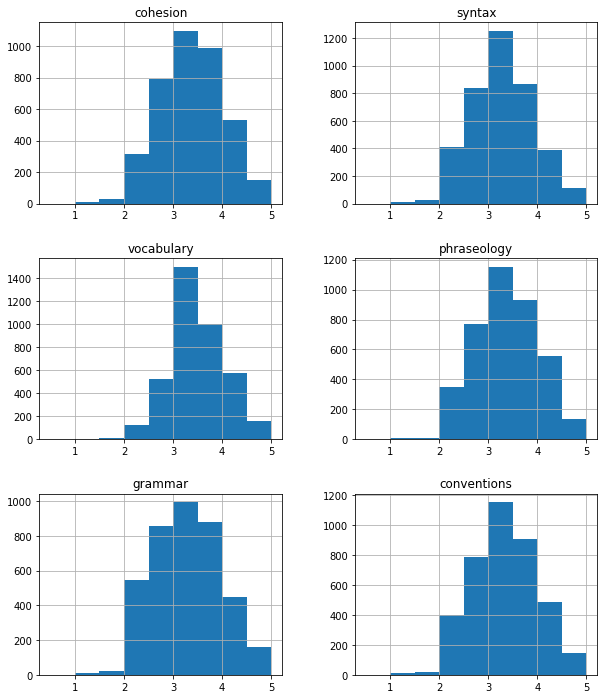

In [10]:
training_data.hist(list(training_data.columns)[2:8], bins = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5], figsize=(10,12))

The next thing we did was take a look at the correlation between grading categories. Engineering features in abstract categories like cohesion seemed difficult. The category which seemed most approachable to engineer features for was vocabulary. Luckily, vocabulary is correlated to the other grading categories. 

In [11]:
training_data.corr()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
cohesion,1.000000,0.695459,0.666151,0.690058,0.638689,0.666151
syntax,0.695459,1.000000,0.680562,0.725467,0.709525,0.700025
vocabulary,0.666151,0.680562,1.000000,0.735261,0.654852,0.664292
phraseology,0.690058,0.725467,0.735261,1.000000,0.719746,0.666842
grammar,0.638689,0.709525,0.654852,0.719746,1.000000,0.673301
conventions,0.666151,0.700025,0.664292,0.666842,0.673301,1.000000


Our first idea for a feature is to develop a vocabulary score. The idea is that people with better vocabulary are probably using a larger percentage of the words in the entire corpus. 

In [12]:
# Split up the text into words
regexp = RegexpTokenizer('\w+')
training_data['text_token'] = training_data['full_text_lower'].apply(regexp.tokenize)

# Since we're evaluating vocabulary, remove words that are less important like "the", "and"
stopwords = nltk.corpus.stopwords.words("english")

training_data['text_token'] = training_data['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
training_data.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,full_text_lower,text_token
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,i think that students would benefit from learn...,"[think, students, would, benefit, learning, ho..."
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,when a problem is a change you have to let it ...,"[problem, change, let, best, matter, happening..."
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,"dear, principal\n\nif u change the school poli...","[dear, principal, u, change, school, policy, g..."
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,the best time in life is when you become yours...,"[best, time, life, become, agree, greatest, ac..."
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,small act of kindness can impact in other peop...,"[small, act, kindness, impact, people, change,..."


We constructed a list of all the unique words in the corpus, ignoring spelling errors. 

In [13]:
all_training_words = []
for words in training_data["text_token"]:
    all_training_words.extend(words)
all_training_words = list(set(all_training_words))
num_unique_words = len(all_training_words)
print("The number of unique words in the training data is:", num_unique_words)

The number of unique words in the training data is: 21249


We then calculated a basic vocabulary score which is the percentage of words each essay used from the entire corpus. We eliminated stop words, words that are very common and don't add vocabulary e.g. 'the'.

In [14]:
training_data["basic_vocab_score"] = [len(set(x))/num_unique_words for x in training_data["text_token"]]
training_data.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,full_text_lower,text_token,basic_vocab_score
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,i think that students would benefit from learn...,"[think, students, would, benefit, learning, ho...",0.004047
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,when a problem is a change you have to let it ...,"[problem, change, let, best, matter, happening...",0.003859
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,"dear, principal\n\nif u change the school poli...","[dear, principal, u, change, school, policy, g...",0.002824
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,the best time in life is when you become yours...,"[best, time, life, become, agree, greatest, ac...",0.006400
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,small act of kindness can impact in other peop...,"[small, act, kindness, impact, people, change,...",0.003247


Our second idea is that longer words probably also indicate a better vocabulary. So we computed the average length of words as well. Again, we removed stop words as this could skew the scores. 

In [18]:
training_data["avg_word_length"] = [statistics.mean(list(map(len, x))) for x in training_data["text_token"]]
training_data.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,full_text_lower,text_token,basic_vocab_score,avg_word_length
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,i think that students would benefit from learn...,"[think, students, would, benefit, learning, ho...",0.004047,5.201550
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,when a problem is a change you have to let it ...,"[problem, change, let, best, matter, happening...",0.003859,5.532710
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,"dear, principal\n\nif u change the school poli...","[dear, principal, u, change, school, policy, g...",0.002824,5.318182
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,the best time in life is when you become yours...,"[best, time, life, become, agree, greatest, ac...",0.006400,5.664286
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,small act of kindness can impact in other peop...,"[small, act, kindness, impact, people, change,...",0.003247,5.437500


We then made a plot of the engineered features on the x-axis against the vocabulary grade on the y-axis. If these features were good we would expect to see higher vocabulary grades only occurring when our feature scores were higher. Unfortunately, this was not the case for either of the features so we had to go back to the drawing board. 

<AxesSubplot:xlabel='basic_vocab_score', ylabel='vocabulary_grade'>

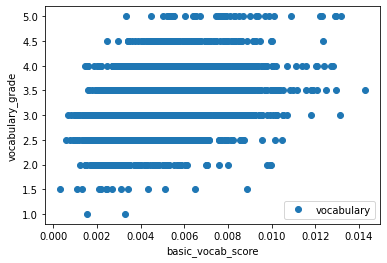

In [19]:
training_data.plot(x='basic_vocab_score', y='vocabulary', style='o', ylabel = "vocabulary_grade")

<AxesSubplot:xlabel='avg_word_length', ylabel='vocabulary_grade'>

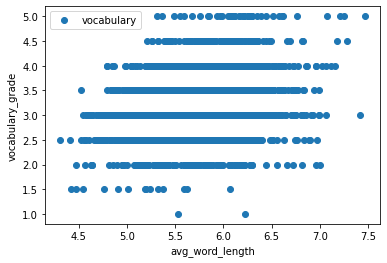

In [20]:
training_data.plot(x='avg_word_length', y='vocabulary', style='o', ylabel = "vocabulary_grade")

# Outliers

One idea we had about outliers, which we didn't pursue due to time constraints, was to consider essays with a high spread in their grades. Where we define spread as the difference between their highest grade and lowest grade. Intuitively, the writing of essays that have a very high grade in one category and a low grade in another category is probably very different from most of the other essays. 

In [21]:
# Consider very high spread, very low spread
training_data["spread"] = training_data.iloc[:,2:8].apply(lambda x: max(x) - min(x), axis = 1)
training_data["spread"]
max_spread = max(training_data["spread"])
spread_outliers = training_data[training_data["spread"] == max_spread]
num_spread_outliers = len(spread_outliers)
spread_outliers

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,full_text_lower,text_token,basic_vocab_score,avg_word_length,spread
582,2C38B62420C3,Dear TEACHER_NAME\n\nI think that we don't nee...,3.0,3.5,3.0,3.0,5.0,3.5,dear teacher_name\n\ni think that we don't nee...,"[dear, teacher_name, think, need, community, s...",0.002071,5.367816,2.0
722,37D67E614E05,Dear TEACHER_NAME\n\nI do think students shoul...,2.0,3.0,3.0,3.0,3.0,4.0,dear teacher_name\n\ni do think students shoul...,"[dear, teacher_name, think, students, communit...",0.000988,6.034483,2.0
784,3CDD56FF3477,"Today, at school, most people are required by ...",5.0,3.5,4.0,3.5,3.0,4.0,"today, at school, most people are required by ...","[today, school, people, required, teachers, wo...",0.005836,5.913043,2.0
1832,8A216BEDA4C2,"I would want to go to France, Generic_City i w...",2.5,2.0,4.0,3.0,3.0,3.0,"i would want to go to france, generic_city i w...","[would, want, go, france, generic_city, would,...",0.004988,4.790476,2.0
1947,92F7DD653EFB,Some people think that is more beneficial work...,4.0,3.0,3.5,2.0,3.0,3.0,some people think that is more beneficial work...,"[people, think, beneficial, working, alone, wo...",0.002871,5.669291,2.0
2556,BE1752DCF09C,Some students take online classes they think i...,3.0,2.0,3.0,3.0,2.5,4.0,some students take online classes they think i...,"[students, take, online, classes, think, good,...",0.002730,5.733696,2.0
3262,E2F767441B44,If in high school should young students be cap...,5.0,4.0,4.0,4.0,3.0,4.0,if in high school should young students be cap...,"[high, school, young, students, capable, commi...",0.005600,5.987234,2.0
3446,EC35456D4E07,"Conserve energy and resources,some businesses ...",2.0,2.0,2.5,2.5,4.0,2.5,"conserve energy and resources,some businesses ...","[conserve, energy, resources, businesses, adop...",0.002071,5.336735,2.0
3457,ECC9E84CD3D1,I think that students should start an after sc...,3.0,3.0,3.0,2.0,4.0,3.5,i think that students should start an after sc...,"[think, students, start, school, homework, clu...",0.002212,6.120968,2.0
3597,F2BAC6095D8A,I belive that students would work more effecti...,3.0,3.5,3.0,3.0,4.0,2.0,i belive that students would work more effecti...,"[belive, students, would, work, effectivelly, ...",0.004424,6.123288,2.0


# Load BERT Encoder

In [ ]:
import transformers as ppb
import torch

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

In [ ]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights, truncation = True, padding = True)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
training_data = pd.read_csv("data/train.csv")
training_data["full_text_lower"] = training_data["full_text"].astype(str).str.lower()
cleaned_data = pd.read_csv("data/cleaned.csv")
training_data.head()

# BERT Encode Training Data in Batches

We first encode our training data using the BERT model. We do this in batches due to memory constraints and save the encoding in a text file to reload later. 

In [ ]:
num_input_ids = len(training_data)
batch_size = 100
num_batches = int(num_input_ids/batch_size)

with open('data/BertEncoding.csv', 'a', newline='') as f_object:  
    for i in range(num_batches):
        print("Batch range is: ", i * batch_size, min((i+1)*batch_size, num_input_ids))
        tokenizer_output = tokenizer(list(training_data['full_text_lower'])[i * batch_size:min((i+1)*batch_size, num_input_ids)], add_special_tokens=True, 
                                                           truncation = True, padding = True, return_attention_mask = True, return_tensors = "pt")
        input_ids = tokenizer_output['input_ids']
        attention_mask = tokenizer_output["attention_mask"]
        with torch.no_grad(): 
                last_hidden_states = model(input_ids, attention_mask=attention_mask)
                np.savetxt(f_object,last_hidden_states[0][:,0,:].numpy(),delimiter=',',fmt='%f')
                

# Read in BERT Encoded Data

We read in the encoded essays and build a function which calculates the individual and average RSME given a classifier, training data and labels.

In [22]:
bert_encoded_training_data = pd.read_csv("data/BertEncoding.csv", header = None)
bert_encoded_training_data

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.029591,-0.097132,0.059457,0.165369,-0.056738,-0.304551,0.515720,0.490612,-0.259699,-0.598605,...,0.066784,-0.430935,0.219690,-0.090140,-0.182325,0.140874,-0.110938,-0.213190,0.248386,0.328340
1,-0.038584,-0.015137,-0.123268,-0.022665,-0.237719,-0.207562,0.261755,0.556195,-0.502778,-0.549189,...,0.072002,-0.536795,0.007473,-0.350114,0.060332,0.283561,-0.073081,-0.103171,0.421613,0.159889
2,-0.093898,-0.037068,0.011076,0.117620,-0.088856,-0.276792,0.289310,0.567711,-0.187136,-0.502904,...,-0.058506,-0.371836,0.030353,-0.167207,-0.139666,0.025361,-0.151827,0.029557,0.457311,0.377178
3,-0.026837,-0.039115,-0.332211,0.052445,-0.045733,-0.139317,0.489169,0.506403,-0.240078,-0.580906,...,0.075844,-0.448586,0.129452,-0.101856,-0.063095,0.279719,0.021416,-0.069962,0.459376,0.225718
4,-0.168148,-0.171669,-0.141218,0.015397,0.029418,-0.196916,0.209078,0.774049,-0.660054,-0.423037,...,-0.067982,-0.448247,0.147778,-0.097391,-0.305021,0.237657,0.033307,-0.382741,0.414850,0.033029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3906,0.219675,0.073528,-0.237438,-0.009554,-0.116485,-0.287817,0.358889,0.567810,-0.094812,-0.281783,...,-0.103016,-0.231311,0.055898,-0.291534,0.222228,0.007023,-0.094847,-0.147935,0.449684,0.255473
3907,-0.136682,0.046676,-0.092843,0.170535,-0.069056,-0.284096,0.255674,0.412818,-0.314843,-0.561639,...,-0.007266,-0.482178,0.116537,-0.084594,-0.154657,0.064647,-0.160637,-0.216604,0.309719,0.234979
3908,-0.042635,0.034022,-0.083136,-0.123123,-0.340256,-0.151419,0.379553,0.277510,-0.033309,-0.415299,...,0.023153,-0.283158,-0.043056,-0.172749,0.036886,0.129780,-0.073406,0.082496,0.447110,0.407554
3909,-0.093317,-0.038759,-0.537204,0.083392,-0.229918,-0.071670,0.325250,0.507643,-0.404548,-0.519141,...,0.020531,-0.378594,-0.003675,-0.081887,0.060458,0.240452,-0.063774,-0.099364,0.352795,0.214748


In [23]:
bert_data_and_labels = pd.concat([bert_encoded_training_data, training_data[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]]], axis = 1, join = 'outer', ignore_index=False, sort=False)
bert_data_and_labels.head()

,0,1,2,3,4,5,6,7,8,9,...,764,765,766,767,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,-0.029591,-0.097132,0.059457,0.165369,-0.056738,-0.304551,0.515720,0.490612,-0.259699,-0.598605,...,-0.110938,-0.213190,0.248386,0.328340,3.5,3.5,3.0,3.0,4.0,3.0
1,-0.038584,-0.015137,-0.123268,-0.022665,-0.237719,-0.207562,0.261755,0.556195,-0.502778,-0.549189,...,-0.073081,-0.103171,0.421613,0.159889,2.5,2.5,3.0,2.0,2.0,2.5
2,-0.093898,-0.037068,0.011076,0.117620,-0.088856,-0.276792,0.289310,0.567711,-0.187136,-0.502904,...,-0.151827,0.029557,0.457311,0.377178,3.0,3.5,3.0,3.0,3.0,2.5
3,-0.026837,-0.039115,-0.332211,0.052445,-0.045733,-0.139317,0.489169,0.506403,-0.240078,-0.580906,...,0.021416,-0.069962,0.459376,0.225718,4.5,4.5,4.5,4.5,4.0,5.0
4,-0.168148,-0.171669,-0.141218,0.015397,0.029418,-0.196916,0.209078,0.774049,-0.660054,-0.423037,...,0.033307,-0.382741,0.414850,0.033029,2.5,3.0,3.0,3.0,2.5,2.5


In [25]:
bert_spell_data_and_labels = pd.concat([bert_encoded_training_data, cleaned_data[["no. spelling error"]], training_data[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]]], axis = 1, join = 'outer', ignore_index=False, sort=False)
bert_spell_data_and_labels.head()

,0,1,2,3,4,5,6,7,8,9,...,765,766,767,no. spelling error,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,-0.029591,-0.097132,0.059457,0.165369,-0.056738,-0.304551,0.515720,0.490612,-0.259699,-0.598605,...,-0.213190,0.248386,0.328340,1,3.5,3.5,3.0,3.0,4.0,3.0
1,-0.038584,-0.015137,-0.123268,-0.022665,-0.237719,-0.207562,0.261755,0.556195,-0.502778,-0.549189,...,-0.103171,0.421613,0.159889,3,2.5,2.5,3.0,2.0,2.0,2.5
2,-0.093898,-0.037068,0.011076,0.117620,-0.088856,-0.276792,0.289310,0.567711,-0.187136,-0.502904,...,0.029557,0.457311,0.377178,0,3.0,3.5,3.0,3.0,3.0,2.5
3,-0.026837,-0.039115,-0.332211,0.052445,-0.045733,-0.139317,0.489169,0.506403,-0.240078,-0.580906,...,-0.069962,0.459376,0.225718,0,4.5,4.5,4.5,4.5,4.0,5.0
4,-0.168148,-0.171669,-0.141218,0.015397,0.029418,-0.196916,0.209078,0.774049,-0.660054,-0.423037,...,-0.382741,0.414850,0.033029,12,2.5,3.0,3.0,3.0,2.5,2.5


We make a comparison between the given classifier and the baseline model. The baseline model chooses the grade which appears most frequently for each category. Another thing to note is that we use a stratified train test split because we have an imbalanced data set. There are very few examples of essays with grades of 1 or grades of 5. 

In [26]:
# RSME Calculator Function, takes as input a classifier
def calculate_RSME(clf, training_data, labels):
    grade_categories = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]
    model_rsmes = []
    baseline_rsmes = []
    for grade_category in grade_categories:
        X_train, X_test, y_train, y_test = train_test_split(training_data, labels[grade_category], test_size=0.2, random_state=42, stratify = bert_data_and_labels[grade_category])
        clf.fit(X_train, y_train * 2)
        baseline_model = statistics.mode(y_train*2)
        model_rsme = mean_squared_error(y_test * 2, clf.predict(X_test))
        baseline_rsme = mean_squared_error(y_test * 2, [baseline_model] * len(y_test))
        model_rsmes +=  [model_rsme]
        baseline_rsmes += [baseline_rsme]
        print(grade_category, "our model", model_rsme, "baseline model", baseline_rsme)
    print("average RSME our model", statistics.mean(model_rsmes), "average RSME baseline model", statistics.mean(baseline_rsmes))


In [33]:
X = bert_data_and_labels.iloc[:,:768]
y = training_data[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]]
X_spell = bert_spell_data_and_labels.iloc[:,:769]
y_spell = y

# Decision Tree Classifier

In [34]:
# Decision Tree Classifier
calculate_RSME(tree.DecisionTreeClassifier(), X, y)


   

cohesion our model 2.528735632183908 baseline model 1.8109833971902938
syntax our model 2.3614303959131546 baseline model 1.6551724137931034
vocabulary our model 1.9782886334610472 baseline model 1.5708812260536398
phraseology our model 2.4980842911877397 baseline model 1.7777777777777777
grammar our model 2.578544061302682 baseline model 1.9744572158365261
conventions our model 2.413793103448276 baseline model 1.8275862068965518
average RSME our model 2.3931460195828014 average RSME baseline model 1.7694763729246488


# RBF Kernel SVM

In [35]:
# RBF Kernel support vector machine
calculate_RSME(SVC(kernel = 'rbf', C=10), X, y)   

cohesion our model 1.2796934865900382 baseline model 1.8109833971902938
syntax our model 1.0970625798212006 baseline model 1.6551724137931034
vocabulary our model 1.0191570881226053 baseline model 1.5708812260536398
phraseology our model 1.2656449553001277 baseline model 1.7777777777777777
grammar our model 1.3614303959131546 baseline model 1.9744572158365261
conventions our model 1.1098339719029373 baseline model 1.8275862068965518
average RSME our model 1.1888037462750107 average RSME baseline model 1.7694763729246488


# RBF Kernel SVM with Spelling Error Numbers

In [36]:
# RBF Kernel support vector machine
calculate_RSME(SVC(kernel = 'rbf', C=10), X_spell, y_spell)   

cohesion our model 1.3065134099616857 baseline model 1.8109833971902938
syntax our model 1.1226053639846743 baseline model 1.6551724137931034
vocabulary our model 1.0357598978288634 baseline model 1.5708812260536398
phraseology our model 1.236270753512133 baseline model 1.7777777777777777
grammar our model 1.4329501915708813 baseline model 1.9744572158365261
conventions our model 1.040868454661558 baseline model 1.8275862068965518
average RSME our model 1.195828011919966 average RSME baseline model 1.7694763729246488


# Random Forest Classifier

In [37]:
# Random Forest Classifier
calculate_RSME(RandomForestClassifier(n_estimators=100), X, y)
   

cohesion our model 1.4240102171136655 baseline model 1.8109833971902938
syntax our model 1.2694763729246488 baseline model 1.6551724137931034
vocabulary our model 1.1251596424010217 baseline model 1.5708812260536398
phraseology our model 1.343550446998723 baseline model 1.7777777777777777
grammar our model 1.4533844189016603 baseline model 1.9744572158365261
conventions our model 1.1890166028097062 baseline model 1.8275862068965518
average RSME our model 1.3007662835249043 average RSME baseline model 1.7694763729246488


# K Nearest Neighbors

In [38]:
from sklearn.neighbors import KNeighborsClassifier
for k in range(5, 10, 1):
    print("k is", k)
    calculate_RSME(KNeighborsClassifier(n_neighbors=k), X, y)

k is 5
cohesion our model 1.9029374201787994 baseline model 1.8109833971902938
syntax our model 1.669220945083014 baseline model 1.6551724137931034
vocabulary our model 1.392081736909323 baseline model 1.5708812260536398
phraseology our model 1.89272030651341 baseline model 1.7777777777777777
grammar our model 2.1417624521072796 baseline model 1.9744572158365261
conventions our model 1.6666666666666667 baseline model 1.8275862068965518
average RSME our model 1.7775649212430822 average RSME baseline model 1.7694763729246488
k is 6
cohesion our model 1.842911877394636 baseline model 1.8109833971902938
syntax our model 1.6513409961685823 baseline model 1.6551724137931034
vocabulary our model 1.3818646232439336 baseline model 1.5708812260536398
phraseology our model 1.8748403575989783 baseline model 1.7777777777777777
grammar our model 2.0319284802043422 baseline model 1.9744572158365261
conventions our model 1.6385696040868454 baseline model 1.8275862068965518
average RSME our model 1.736

In [39]:
# Trying the square root of num samples rule of thumb
k = int(math.sqrt(len(training_data) * .8))
print("k is", k)
calculate_RSME(KNeighborsClassifier(n_neighbors=k), X, y)

k is 55
cohesion our model 1.5632183908045978 baseline model 1.8109833971902938
syntax our model 1.40485312899106 baseline model 1.6551724137931034
vocabulary our model 1.1851851851851851 baseline model 1.5708812260536398
phraseology our model 1.3933588761174969 baseline model 1.7777777777777777
grammar our model 1.5938697318007662 baseline model 1.9744572158365261
conventions our model 1.288633461047254 baseline model 1.8275862068965518
average RSME our model 1.40485312899106 average RSME baseline model 1.7694763729246488


# Naive Bayes Classifier

In [40]:
# Naive Bayes
calculate_RSME(GaussianNB(), X, y)

cohesion our model 2.9936143039591316 baseline model 1.8109833971902938
syntax our model 2.2784163473818646 baseline model 1.6551724137931034
vocabulary our model 2.40485312899106 baseline model 1.5708812260536398
phraseology our model 2.4086845466155813 baseline model 1.7777777777777777
grammar our model 2.7228607918263092 baseline model 1.9744572158365261
conventions our model 2.318007662835249 baseline model 1.8275862068965518
average RSME our model 2.521072796934866 average RSME baseline model 1.7694763729246488


In [41]:
# Multinomial Bayes with normalization
p = Pipeline([('Normalizing', MinMaxScaler()),('MultinomialNB', MultinomialNB())])
calculate_RSME(p, X, y)

cohesion our model 1.7777777777777777 baseline model 1.8109833971902938
syntax our model 1.3652618135376755 baseline model 1.6551724137931034
vocabulary our model 1.2835249042145593 baseline model 1.5708812260536398
phraseology our model 1.6845466155810984 baseline model 1.7777777777777777
grammar our model 1.7151979565772668 baseline model 1.9744572158365261
conventions our model 1.3588761174968071 baseline model 1.8275862068965518
average RSME our model 1.5308641975308641 average RSME baseline model 1.7694763729246488


After comparing the average RSME of all these models we settled on the SVM model with RBF kernel. We also adapted a LSTM CNN model made publicly availabe on Kaggle in another notebook called LSTM.ipynb in the same directory. The SVM model also outperformed this model. For these comparisons the metric used was lowest average RSME, one of our key performance indicators. 

We then made another attempt at engineering a feature to try to improve the SVM model. The idea was to compute the frequency of each word that appears in the corpus (ignoring stop words) and then something together 1/(frequency) of these scores to give a higher weighting to more rare words. One issue with this idea is that many words appeared as being infrequent because they were misspelled. So we first spell-corrected the words and then computed the rarity score. 

In [42]:
# Split up the text into words
regexp = RegexpTokenizer('\w+')
cleaned_data['text_token'] = cleaned_data['text_spelling'].apply(regexp.tokenize)

# Since we're evaluating vocabulary, remove words that are less important like "the", "and"
stopwords = nltk.corpus.stopwords.words("english")

cleaned_data['text_token'] = cleaned_data['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
cleaned_data.head()

,Unnamed: 0,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,text_n,text_nc,text_lmtz,text_spelling,no. spelling error,wrong_spelling,correct_spelling,text_token
0,0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,i think that students would benefit from learn...,i think that students would benefit from learn...,i think that student would benefit from learni...,i think that students would benefit from learn...,1,['cloths'],['clothes'],"[think, students, would, benefit, learning, ho..."
1,1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,when a problem is a change you have to let it ...,when a problem is a change you have to let it ...,when a problem is a change you have to let it ...,when a problem is a change you have to let it ...,3,"['tings', 'wok', 'ruing']","['things', 'work', 'ring']","[problem, change, let, best, matter, happening..."
2,2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,"dear, principal if u change the school policy...","dear, principal if you change the school poli...",dear principal if you change the school policy...,dear principal if you change the school policy...,0,[],[],"[dear, principal, change, school, policy, grad..."
3,3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,the best time in life is when you become yours...,the best time in life is when you become yours...,the best time in life is when you become yours...,the best time in life is when you become yours...,0,[],[],"[best, time, life, become, agree, greatest, ac..."
4,4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,small act of kindness can impact in other peop...,small act of kindness can impact in other peop...,small act of kindness can impact in other peop...,small act of kindness can impact in other peop...,12,"['kindess', 'homeles', 'triying', 'greate', 'k...","['kindness', 'homeless', 'trying', 'create', '...","[small, act, kindness, impact, people, change,..."


In [43]:
all_tokens = []
for tokens in cleaned_data["text_token"]:
    all_tokens += tokens
all_tokens = set(all_tokens)
word_frequencies = dict.fromkeys(list(all_tokens), 0)
all_tokens = []
for tokens in cleaned_data["text_token"]:
    for token in tokens:
        word_frequencies[token] = word_frequencies[token] + 1

In [44]:
def compute_rarity_score(tokens):
    sum = 0
    for token in tokens:
        sum += 1/word_frequencies[token]
    return sum/(len(tokens))

In [45]:
vocab_freq_scores = list(map(compute_rarity_score, cleaned_data["text_token"]))
cleaned_data["vocab_freq"] = vocab_freq_scores

In [46]:
bert_spell_voc_labels = pd.concat([bert_encoded_training_data, cleaned_data["vocab_freq"], training_data[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]]], axis = 1, join = 'outer', ignore_index=False, sort=False)
bert_spell_voc_labels.head()

,0,1,2,3,4,5,6,7,8,9,...,765,766,767,vocab_freq,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,-0.029591,-0.097132,0.059457,0.165369,-0.056738,-0.304551,0.515720,0.490612,-0.259699,-0.598605,...,-0.213190,0.248386,0.328340,0.022152,3.5,3.5,3.0,3.0,4.0,3.0
1,-0.038584,-0.015137,-0.123268,-0.022665,-0.237719,-0.207562,0.261755,0.556195,-0.502778,-0.549189,...,-0.103171,0.421613,0.159889,0.009831,2.5,2.5,3.0,2.0,2.0,2.5
2,-0.093898,-0.037068,0.011076,0.117620,-0.088856,-0.276792,0.289310,0.567711,-0.187136,-0.502904,...,0.029557,0.457311,0.377178,0.006167,3.0,3.5,3.0,3.0,3.0,2.5
3,-0.026837,-0.039115,-0.332211,0.052445,-0.045733,-0.139317,0.489169,0.506403,-0.240078,-0.580906,...,-0.069962,0.459376,0.225718,0.008312,4.5,4.5,4.5,4.5,4.0,5.0
4,-0.168148,-0.171669,-0.141218,0.015397,0.029418,-0.196916,0.209078,0.774049,-0.660054,-0.423037,...,-0.382741,0.414850,0.033029,0.005223,2.5,3.0,3.0,3.0,2.5,2.5


In [47]:
calculate_RSME(SVC(kernel = 'rbf', C=10), bert_spell_voc_labels.iloc[:,:769], training_data[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]])

cohesion our model 1.2796934865900382 baseline model 1.8109833971902938
syntax our model 1.0957854406130267 baseline model 1.6551724137931034
vocabulary our model 1.0191570881226053 baseline model 1.5708812260536398
phraseology our model 1.2656449553001277 baseline model 1.7777777777777777
grammar our model 1.3614303959131546 baseline model 1.9744572158365261
conventions our model 1.1098339719029373 baseline model 1.8275862068965518
average RSME our model 1.188590889740315 average RSME baseline model 1.7694763729246488


Adding in this feature makes the SVM model perform slightly worse, though essentially the same. This likely means that the information that the frequency score contains is already contained in the BERT encoding. 

# Future Directions

There are three main areas in which this project can be improved. The BERT model has a maximum text input length of 512 words. So to deal with this we currently only consider the first 512 words in an essay. To improve this, we could split an essay into chunks, grade each individual chunk and then average the grades. Another way we could improve the model would be to include more training data. There is additional data available from a similar Kaggle competition that we could try to leverage. Lastly, there is clearly a lot of room for better feature engineering. With more knowledge of NLP we could try to build features that might improve grading in categories other than vocabulary.  